# GNN-based URA Clustering

This notebook trains a Graph Neural Network to cluster a $16 \times 16$ antenna array.

In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '..')

from gnn import (
    URAConfig,
    create_ura_graph,
    compute_mutual_coupling,
    train_ura_clustering,
    train_ura_clustering_simple,
    assignments_to_antenna_format,
)

torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")

PyTorch: 2.9.1+cpu
CUDA: False


## 1. Configuration

In [10]:
config = URAConfig(rows=16, cols=16, dx=0.5, dy=0.7, freq_ghz=10.0)
print(f"Array: {config.N} elements")
print(f"Spacing: dx={config.dx}λ, dy={config.dy}λ")

Array: 256 elements
Spacing: dx=0.5λ, dy=0.7λ


## 2. Train GNN

Using the **simple** training mode which is more stable.

In [11]:
num_clusters = 4

print("Training GNN (simple mode)...\n")
clusters = train_ura_clustering_simple(
    config,
    num_clusters=num_clusters,
    epochs=300,
    verbose=True
)

# Get cluster sizes (handle missing clusters)
unique_clusters = np.unique(clusters)
sizes = np.bincount(clusters, minlength=num_clusters)
print(f"\nCluster sizes: {sizes.tolist()}")
print(f"Unique clusters found: {unique_clusters.tolist()}")

Training GNN (simple mode)...

Epoch 100: Loss=-0.8988, Sizes=[66, 63, 64, 63]
Epoch 200: Loss=-0.9024, Sizes=[65, 67, 64, 60]
Epoch 300: Loss=-0.9032, Sizes=[66, 64, 67, 59]

Cluster sizes: [64, 65, 66, 61]
Unique clusters found: [0, 1, 2, 3]


## 3. Visualize Results

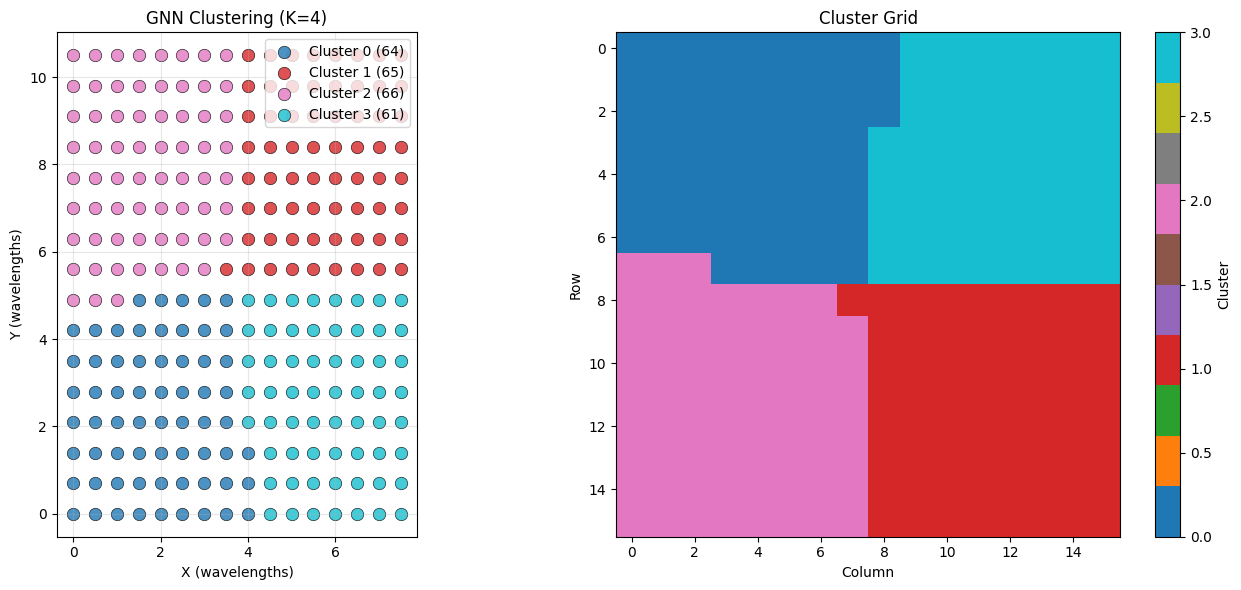


Cluster grid:
[[0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3]
 [0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3]
 [2 2 2 0 0 0 0 0 3 3 3 3 3 3 3 3]
 [2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1]]


In [12]:
# Get positions
positions, _, _, _ = create_ura_graph(config, use_coupling=False)
pos_np = positions.numpy()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot
colors = plt.cm.tab10(np.linspace(0, 1, num_clusters))
sizes_array = np.bincount(clusters, minlength=num_clusters)

for k in range(num_clusters):
    mask = clusters == k
    if mask.sum() > 0:  # Only plot if cluster has elements
        axes[0].scatter(pos_np[mask, 0], pos_np[mask, 1],
                        c=[colors[k]], s=80, 
                        label=f'Cluster {k} ({sizes_array[k]})',
                        alpha=0.8, edgecolors='black', linewidth=0.5)

axes[0].set_xlabel('X (wavelengths)')
axes[0].set_ylabel('Y (wavelengths)')
axes[0].set_title(f'GNN Clustering (K={num_clusters})')
axes[0].legend(loc='upper right')
axes[0].set_aspect('equal')
axes[0].grid(True, alpha=0.3)

# Grid view
grid = clusters.reshape(config.rows, config.cols)
im = axes[1].imshow(grid, cmap='tab10', vmin=0, vmax=num_clusters-1)
axes[1].set_title('Cluster Grid')
axes[1].set_xlabel('Column')
axes[1].set_ylabel('Row')
plt.colorbar(im, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

print("\nCluster grid:")
print(grid)

## 4. (Optional) Physics-Informed Training

This uses mutual coupling but may need parameter tuning.

In [13]:
print("Training GNN (physics-informed mode)...\n")
clusters_physics = train_ura_clustering(
    config,
    num_clusters=num_clusters,
    epochs=500,
    lr=0.001,
    use_physics=True,
    lambda_balance=10.0,  # HIGH to force balanced clusters
    lambda_contiguity=0.1,
    verbose=True
)

sizes_physics = np.bincount(clusters_physics, minlength=num_clusters)
print(f"\nPhysics-informed cluster sizes: {sizes_physics.tolist()}")

Training GNN (physics-informed mode)...

Epoch 100: Loss=0.4052 | Sizes=[93, 37, 45, 81] | cut=-1.000, bal=0.000
Epoch 200: Loss=0.4052 | Sizes=[68, 35, 65, 88] | cut=-1.000, bal=0.000
Epoch 300: Loss=0.4052 | Sizes=[74, 36, 55, 91] | cut=-1.000, bal=0.000
Epoch 400: Loss=0.4052 | Sizes=[81, 38, 46, 91] | cut=-1.000, bal=0.000
Epoch 500: Loss=0.4052 | Sizes=[81, 38, 46, 91] | cut=-1.000, bal=0.000

Physics-informed cluster sizes: [81, 38, 47, 90]


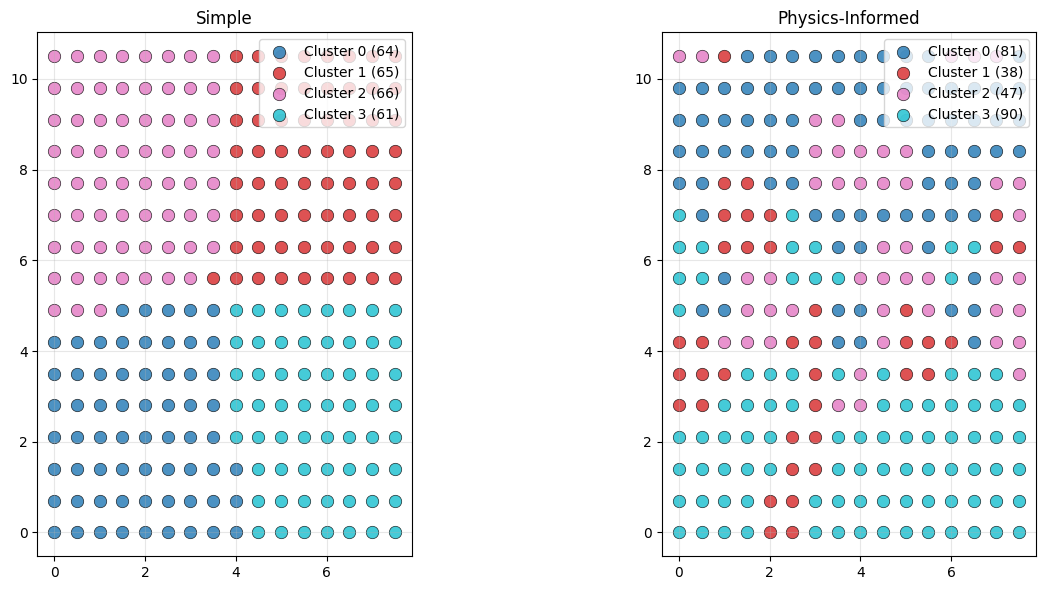

In [14]:
# Compare both results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, cl, title in [(axes[0], clusters, 'Simple'), 
                       (axes[1], clusters_physics, 'Physics-Informed')]:
    sizes_cl = np.bincount(cl, minlength=num_clusters)
    for k in range(num_clusters):
        mask = cl == k
        if mask.sum() > 0:
            ax.scatter(pos_np[mask, 0], pos_np[mask, 1],
                      c=[colors[k]], s=80,
                      label=f'Cluster {k} ({sizes_cl[k]})',
                      alpha=0.8, edgecolors='black', linewidth=0.5)
    ax.set_title(title)
    ax.legend(loc='upper right')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Radiation Pattern (if available)

=== GNN Simple - Radiation Pattern ===


C:\Users\Andrea\AppData\Local\Temp\ipykernel_37564\3456872387.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


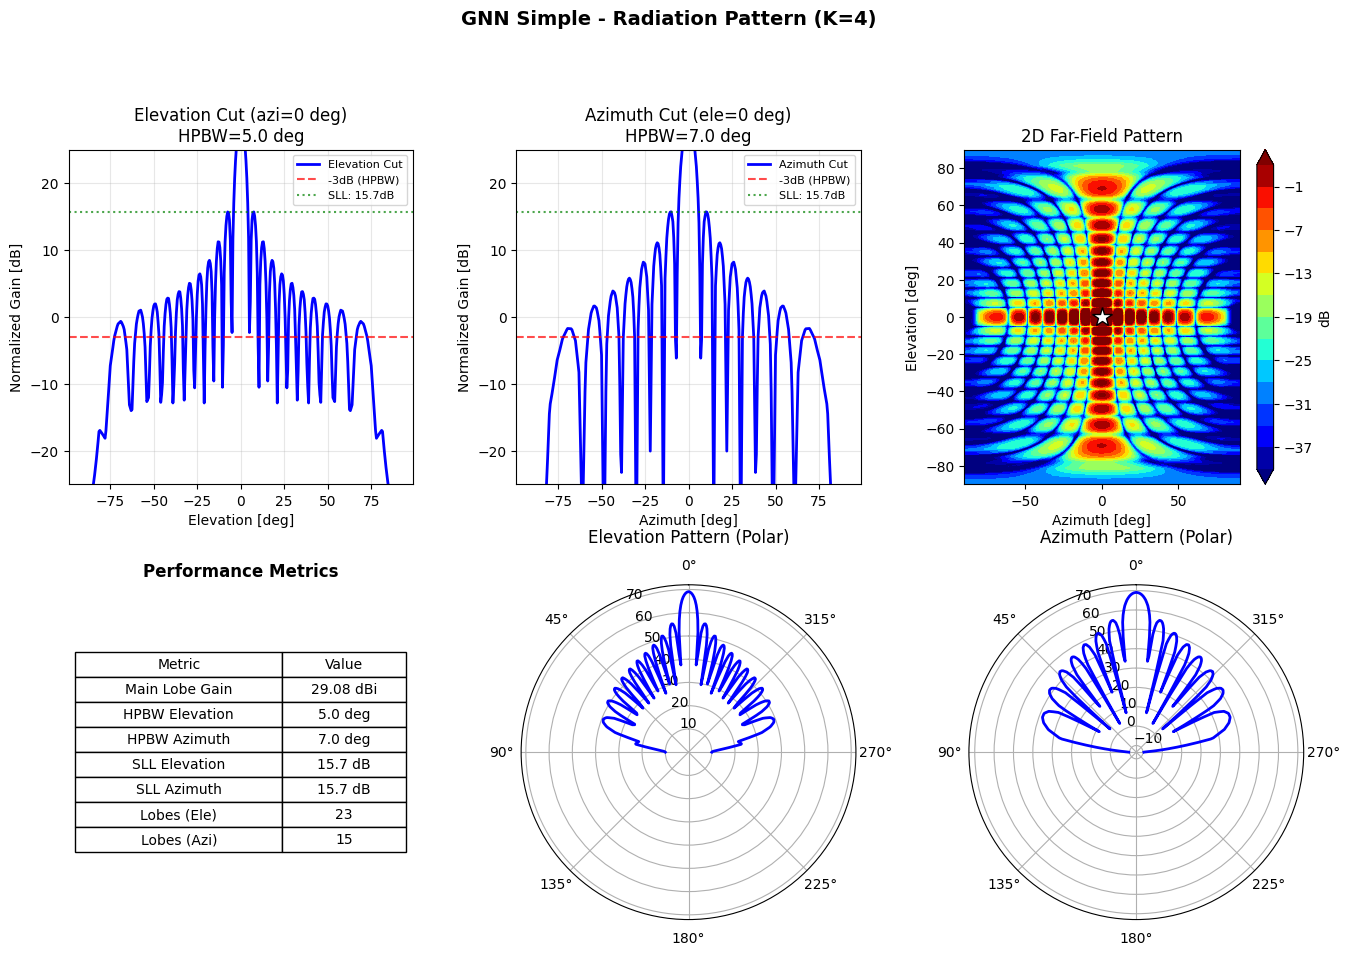


=== GNN Physics-Informed - Radiation Pattern ===


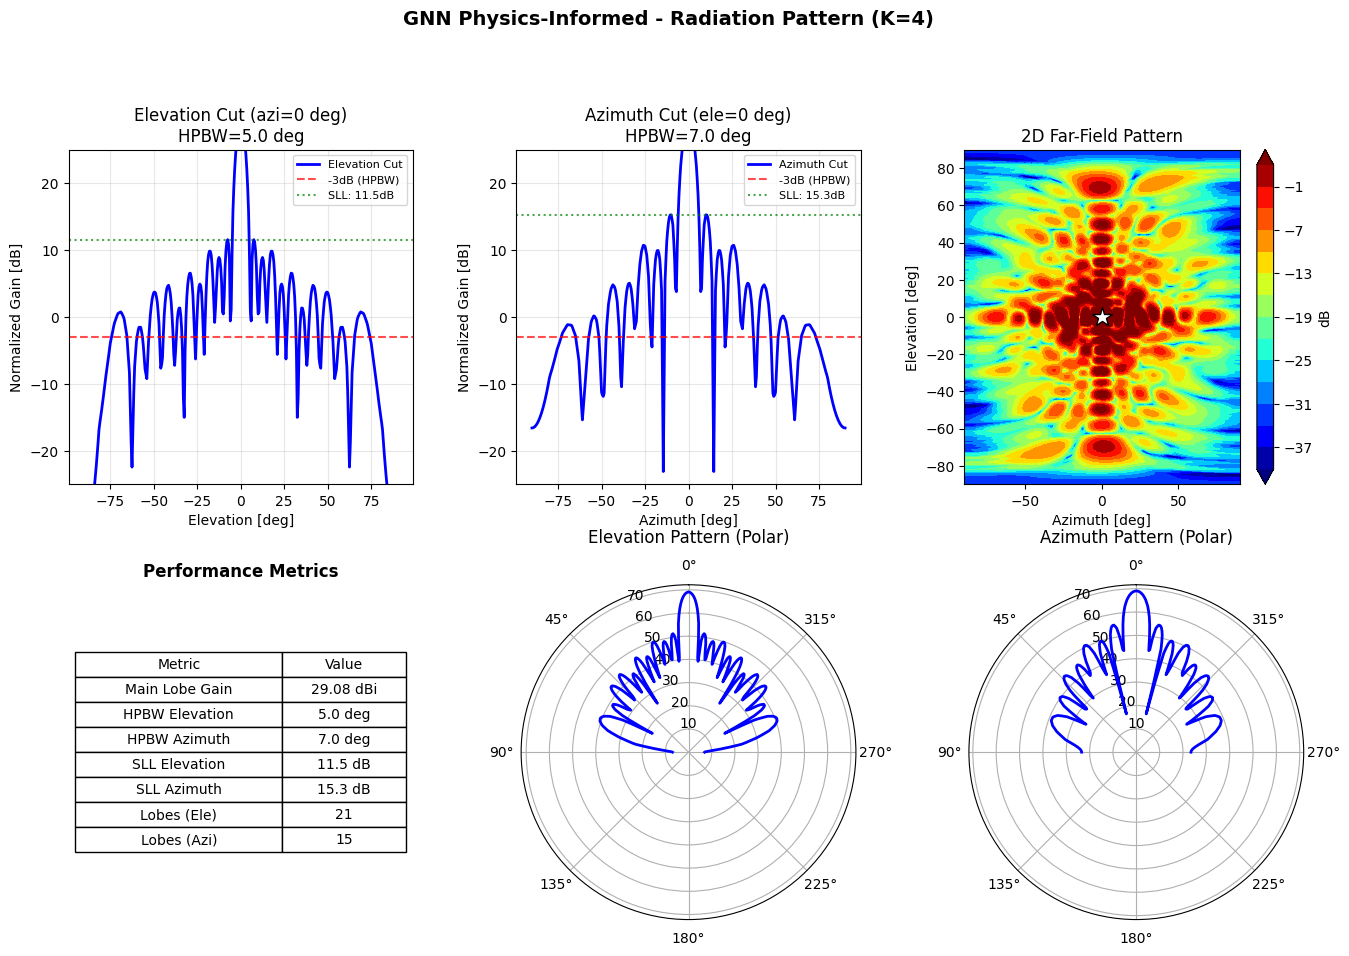

In [15]:
from matplotlib.gridspec import GridSpec
from scipy.signal import find_peaks

sys.path.insert(0, '../optimization/pyvers')
from antenna_physics import LatticeConfig, SystemConfig, MaskConfig, ElementPatternConfig, AntennaArray

def extract_lobe_metrics(FF_I_dB, azi, ele, azi0, ele0, G_boresight=None):
    ele_idx = np.argmin(np.abs(ele - ele0))
    azi_idx = np.argmin(np.abs(azi - azi0))
    ele_cut = FF_I_dB[:, azi_idx]
    azi_cut = FF_I_dB[ele_idx, :]
    main_lobe_gain = G_boresight if G_boresight else np.max(FF_I_dB)

    def find_hpbw(cut, angles):
        max_idx = np.argmax(cut)
        threshold = cut[max_idx] - 3
        left_idx = max_idx
        for i in range(max_idx, -1, -1):
            if cut[i] < threshold:
                left_idx = i
                break
        right_idx = max_idx
        for i in range(max_idx, len(cut)):
            if cut[i] < threshold:
                right_idx = i
                break
        return angles[right_idx] - angles[left_idx]

    hpbw_ele = find_hpbw(ele_cut, ele)
    hpbw_azi = find_hpbw(azi_cut, azi)

    def find_sll_relative(cut, angles):
        max_val = np.max(cut)
        peaks, _ = find_peaks(cut)
        threshold = max_val - 3
        side_peaks = [p for p in peaks if cut[p] < threshold]
        if side_peaks:
            return max(cut[p] for p in side_peaks)
        return -30

    sll_ele_relative = find_sll_relative(ele_cut, ele)
    sll_azi_relative = find_sll_relative(azi_cut, azi)
    peaks_ele, _ = find_peaks(ele_cut, height=-30)
    peaks_azi, _ = find_peaks(azi_cut, height=-30)

    return {
        'main_lobe_gain': main_lobe_gain, 'hpbw_ele': hpbw_ele, 'hpbw_azi': hpbw_azi,
        'sll_ele_relative': sll_ele_relative, 'sll_azi_relative': sll_azi_relative,
        'n_lobes_ele': len(peaks_ele), 'n_lobes_azi': len(peaks_azi),
        'ele_cut': ele_cut, 'azi_cut': azi_cut,
    }

def plot_lobe_analysis(FF_I_dB, antenna_array, G_boresight=None, title="Lobe Analysis"):
    ele0 = antenna_array.system.ele0
    azi0 = antenna_array.system.azi0
    ele = antenna_array.ele
    azi = antenna_array.azi
    metrics = extract_lobe_metrics(FF_I_dB, azi, ele, azi0, ele0, G_boresight)

    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(ele, metrics['ele_cut'], 'b-', linewidth=2, label='Elevation Cut')
    ax1.axhline(y=-3, color='r', linestyle='--', alpha=0.7, label='-3dB (HPBW)')
    ax1.axhline(y=metrics['sll_ele_relative'], color='g', linestyle=':', alpha=0.7,
                label=f"SLL: {metrics['sll_ele_relative']:.1f}dB")
    ax1.set_xlabel('Elevation [deg]'); ax1.set_ylabel('Normalized Gain [dB]')
    ax1.set_title(f"Elevation Cut (azi={azi0} deg)\nHPBW={metrics['hpbw_ele']:.1f} deg")
    ax1.legend(loc='upper right', fontsize=8); ax1.grid(True, alpha=0.3); ax1.set_ylim([-25, 25])

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(azi, metrics['azi_cut'], 'b-', linewidth=2, label='Azimuth Cut')
    ax2.axhline(y=-3, color='r', linestyle='--', alpha=0.7, label='-3dB (HPBW)')
    ax2.axhline(y=metrics['sll_azi_relative'], color='g', linestyle=':', alpha=0.7,
                label=f"SLL: {metrics['sll_azi_relative']:.1f}dB")
    ax2.set_xlabel('Azimuth [deg]'); ax2.set_ylabel('Normalized Gain [dB]')
    ax2.set_title(f"Azimuth Cut (ele={ele0} deg)\nHPBW={metrics['hpbw_azi']:.1f} deg")
    ax2.legend(loc='upper right', fontsize=8); ax2.grid(True, alpha=0.3); ax2.set_ylim([-25, 25])

    ax3 = fig.add_subplot(gs[0, 2])
    levels = np.arange(-40, 5, 3)
    contour = ax3.contourf(antenna_array.AZI, antenna_array.ELE, FF_I_dB,
                           levels=levels, cmap='jet', extend='both')
    plt.colorbar(contour, ax=ax3, label='dB')
    ax3.plot(azi0, ele0, 'w*', markersize=15, markeredgecolor='k')
    ax3.set_xlabel('Azimuth [deg]'); ax3.set_ylabel('Elevation [deg]')
    ax3.set_title('2D Far-Field Pattern')

    ax4 = fig.add_subplot(gs[1, 0]); ax4.axis('off')
    table_data = [
        ['Main Lobe Gain', f"{metrics['main_lobe_gain']:.2f} dBi"],
        ['HPBW Elevation', f"{metrics['hpbw_ele']:.1f} deg"],
        ['HPBW Azimuth', f"{metrics['hpbw_azi']:.1f} deg"],
        ['SLL Elevation', f"{metrics['sll_ele_relative']:.1f} dB"],
        ['SLL Azimuth', f"{metrics['sll_azi_relative']:.1f} dB"],
        ['Lobes (Ele)', f"{metrics['n_lobes_ele']}"],
        ['Lobes (Azi)', f"{metrics['n_lobes_azi']}"],
    ]
    table = ax4.table(cellText=table_data, colLabels=['Metric', 'Value'],
                      loc='center', cellLoc='center', colWidths=[0.5, 0.3])
    table.auto_set_font_size(False); table.set_fontsize(10); table.scale(1.2, 1.5)
    ax4.set_title('Performance Metrics', fontsize=12, fontweight='bold')

    ax5 = fig.add_subplot(gs[1, 1], projection='polar')
    ax5.plot(np.deg2rad(ele), metrics['ele_cut'] + 40, 'b-', linewidth=2)
    ax5.set_theta_zero_location('N'); ax5.set_title('Elevation Pattern (Polar)', y=1.1)

    ax6 = fig.add_subplot(gs[1, 2], projection='polar')
    ax6.plot(np.deg2rad(azi), metrics['azi_cut'] + 40, 'b-', linewidth=2)
    ax6.set_theta_zero_location('N'); ax6.set_title('Azimuth Pattern (Polar)', y=1.1)

    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    return metrics

def compute_radiation(cl, num_cl, grid_shape, title):
    clusters_antenna = assignments_to_antenna_format(cl, grid_shape=grid_shape)
    lattice = LatticeConfig(Nz=16, Ny=16, dist_z=0.7, dist_y=0.5, lattice_type=1)
    system = SystemConfig(freq=29.5e9, azi0=0, ele0=0, dele=0.5, dazi=0.5)
    mask = MaskConfig(elem=30, azim=60, SLL_level=20, SLLin=15)
    eef = ElementPatternConfig(P=1, Gel=5, load_file=0)
    array = AntennaArray(lattice, system, mask, eef)
    result_ff = array.evaluate_clustering(clusters_antenna)
    lobe_metrics = plot_lobe_analysis(result_ff['FF_I_dB'], array,
                                      G_boresight=result_ff['G_boresight'], title=title)
    lobe_metrics['sll_in'] = result_ff['sll_in']
    lobe_metrics['sll_out'] = result_ff['sll_out']
    lobe_metrics['Cm'] = result_ff['Cm']
    return lobe_metrics

print("=== GNN Simple - Radiation Pattern ===")
metrics_simple = compute_radiation(clusters, num_clusters, (config.rows, config.cols),
                                   f"GNN Simple - Radiation Pattern (K={num_clusters})")

print("\n=== GNN Physics-Informed - Radiation Pattern ===")
metrics_physics = compute_radiation(clusters_physics, num_clusters, (config.rows, config.cols),
                                    f"GNN Physics-Informed - Radiation Pattern (K={num_clusters})")

## 6. Simple vs Physics-Informed Comparison

In [16]:
try:
    print("="*70)
    print("  COMPARISON: GNN SIMPLE vs GNN PHYSICS-INFORMED")
    print("="*70)
    print()
    print(f"{'Metric':<30} {'GNN Simple':>20} {'Physics-Informed':>20}")
    print("-"*70)
    print(f"{'Cluster Sizes':<30} {str(sizes.tolist()):>20} {str(sizes_physics.tolist()):>20}")
    print(f"{'Size Std Dev':<30} {np.std(sizes):>20.1f} {np.std(sizes_physics):>20.1f}")
    print("-"*70)
    print(f"{'Cost Function (Cm)':<30} {metrics_simple['Cm']:>20d} {metrics_physics['Cm']:>20d}")
    print(f"{'Main Lobe Gain [dBi]':<30} {metrics_simple['main_lobe_gain']:>20.2f} {metrics_physics['main_lobe_gain']:>20.2f}")
    print(f"{'HPBW Elevation [deg]':<30} {metrics_simple['hpbw_ele']:>20.1f} {metrics_physics['hpbw_ele']:>20.1f}")
    print(f"{'HPBW Azimuth [deg]':<30} {metrics_simple['hpbw_azi']:>20.1f} {metrics_physics['hpbw_azi']:>20.1f}")
    print(f"{'SLL out FoV [dB]':<30} {metrics_simple['sll_out']:>20.2f} {metrics_physics['sll_out']:>20.2f}")
    print(f"{'SLL in FoV [dB]':<30} {metrics_simple['sll_in']:>20.2f} {metrics_physics['sll_in']:>20.2f}")
    print(f"{'SLL Elevation (rel) [dB]':<30} {metrics_simple['sll_ele_relative']:>20.1f} {metrics_physics['sll_ele_relative']:>20.1f}")
    print(f"{'SLL Azimuth (rel) [dB]':<30} {metrics_simple['sll_azi_relative']:>20.1f} {metrics_physics['sll_azi_relative']:>20.1f}")
    print(f"{'Lobes (Elevation)':<30} {metrics_simple['n_lobes_ele']:>20d} {metrics_physics['n_lobes_ele']:>20d}")
    print(f"{'Lobes (Azimuth)':<30} {metrics_simple['n_lobes_azi']:>20d} {metrics_physics['n_lobes_azi']:>20d}")
    print("="*70)
except NameError:
    print("Radiation pattern metrics not available. Run the radiation pattern cells first.")

  COMPARISON: GNN SIMPLE vs GNN PHYSICS-INFORMED

Metric                                   GNN Simple     Physics-Informed
----------------------------------------------------------------------
Cluster Sizes                      [64, 65, 66, 61]     [81, 38, 47, 90]
Size Std Dev                                    1.9                 22.0
----------------------------------------------------------------------
Cost Function (Cm)                              471                  443
Main Lobe Gain [dBi]                          29.08                29.08
HPBW Elevation [deg]                            5.0                  5.0
HPBW Azimuth [deg]                              7.0                  7.0
SLL out FoV [dB]                             -25.29               -24.31
SLL in FoV [dB]                              -13.42               -13.81
SLL Elevation (rel) [dB]                       15.7                 11.5
SLL Azimuth (rel) [dB]                         15.7                 15.3
Lobes